# Project Part 2 Solutions

## (a)

In [1]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old'] #4 by 4
N=file['N'] #population for each of the 100 nodes
Svc_0_PMF=file['Svc_0_PMF'] #respective pmf for each of the 100 nodes
Lc=file['Lc'] #len 4 for c categories
Ic_0=file['Ic_0'] #100 arrays, each len 4 for c categories
gamma=file['gamma']
L_observed=file['L_observed'] #100 rows by 120 columns
nb_nodes = Svc_0_PMF.shape[0] #100 nodes

In [2]:
N.shape

(100,)

In [3]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [4]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate(
        (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(
        SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]


alpha_predicted = np.zeros((nb_nodes))

In [5]:
print(S.shape) #100 nodes, 4 v, 4 c, 200 days
print(I.shape)
print(R.shape)

(100, 4, 4, 200)
(100, 4, 200)
(100, 200)


In [6]:
def loss_func(alpha):
    
    ###### WRITE YOUR FUNCTION HERE
    mse = 0
    
    initial_conditions = np.concatenate(
        (S[node_index,:,:,9].flatten(), I[node_index,:,9], [R[node_index,9]]))

    soln = solve_ivp(
        SIR, (t[9], t[30]), initial_conditions, args=(N_node, alpha*beta_old, gamma), t_eval=t[10:30])

    S[node_index, :, :, 10:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 10:30] = soln.y[16:20]
    R[node_index, 10:30] = soln.y[20]
    L[node_index, 10:30] = Lc@soln.y[16:20]
    
    mse = mean_squared_error(L_observed[node_index, 10:30], L[node_index, 10:30])

    return mse

for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False)


In [30]:
sorted_alpha_predicted=np.array([sorted(alpha_predicted)])[0]
sorted_alpha_predicted

array([0.13437347, 0.14959717, 0.15996704, 0.16158829, 0.16306152,
       0.16851807, 0.17086182, 0.17155762, 0.17612305, 0.17961426,
       0.18221436, 0.18603516, 0.18710937, 0.19025879, 0.20031738,
       0.20330505, 0.20419922, 0.20612793, 0.20684509, 0.2128418 ,
       0.21408691, 0.2162323 , 0.21859131, 0.22739868, 0.23042603,
       0.23352203, 0.24157715, 0.24465332, 0.24894104, 0.25119629,
       0.25798035, 0.25991821, 0.26757812, 0.26948242, 0.27169952,
       0.27301636, 0.28005524, 0.28283691, 0.28662109, 0.28800049,
       0.2930542 , 0.2992981 , 0.29938354, 0.30321045, 0.30422821,
       0.30437317, 0.30966797, 0.31420898, 0.32382202, 0.3296875 ,
       0.32988281, 0.33074341, 0.33313293, 0.33355408, 0.3498291 ,
       0.35234375, 0.35657806, 0.35756836, 0.35844421, 0.36207275,
       0.36960449, 0.37071838, 0.37946777, 0.38393707, 0.3860054 ,
       0.39033203, 0.40922546, 0.41445465, 0.41787415, 0.41876221,
       0.42476807, 0.43438721, 0.43756104, 0.44870605, 0.44996

## (b)

In [8]:
for i in range(100):  
    initial_conditions = np.concatenate(
        (S[i,:,:,29].flatten(), I[i,:,29], [R[i,29]]))

    soln = solve_ivp(
        SIR, (t[29], t[199]), initial_conditions, args=(N[i], alpha_predicted[i]*beta_old, gamma), t_eval=t[30:200])

    S[i, :, :, 30:200] = soln.y[:16].reshape(4, 4, -1)
    I[i, :, 30:200] = soln.y[16:20]
    R[i, 30:200] = soln.y[20]
    L[i, 30:200] = Lc@soln.y[16:20]
    


In [9]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = ((2**(1/alpha))-2)/(2*10**(-3))
    return money

import matplotlib.pyplot as plt 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(alpha_predicted, alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")

    
S_after = np.zeros((nb_nodes, 4, 4, len(t)))
I_after = np.zeros((nb_nodes, 4, len(t)))
R_after = np.zeros((nb_nodes, len(t)))
L_after = np.zeros((nb_nodes, len(t)))
def total_recovered_difference(alpha_afterNPI):
    
    for i in range(100):  
        initial_conditions = np.concatenate(
            (S[i,:,:,29].flatten(), I[i,:,29], [R[i,29]]))

        soln = solve_ivp(
            SIR, (t[29], t[199]), initial_conditions, args=(N[i], alpha_afterNPI[i]*beta_old, gamma), t_eval=t[30:200])

        S_after[i, :, :, 30:200] = soln.y[:16].reshape(4, 4, -1)
        I_after[i, :, 30:200] = soln.y[16:20]
        R_after[i, 30:200] = soln.y[20]
        L_after[i, 30:200] = Lc@soln.y[16:20]

    difference = abs(np.sum(R_after[:,-1] - R[:,-1]))
    
    return difference

### Policy #1

i.

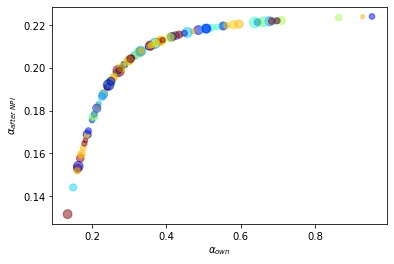

In [10]:
import matplotlib.pyplot as plt 
import numpy as np

scatter_plot(g(g_inv(alpha_predicted)+10000))

There's a logarithmic relationship between our $\alpha_{own}$ values and the alpha_afterNPI values. For alpha_predicted values greater than 0.4, it seems that the values after the intervention doesn't change as much. The rate of growth seems to have to levelled off after this point. 

ii. 

In [11]:
total_recovered_difference(g(g_inv(alpha_predicted)+10000))

320436.6973378926

### Policy #2

i. 

In [12]:
z= np.zeros(100)
for i in range(100):
    z[i] = N[i]/np.sum(N) * 1000000

In [13]:
alpha_afterNPI2 = g(g_inv(alpha_predicted)+z)

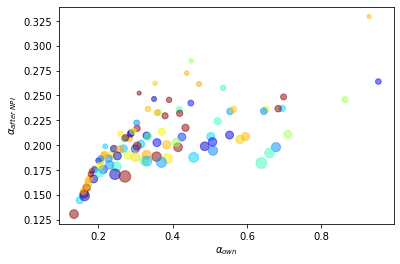

In [14]:
scatter_plot(alpha_afterNPI2)

Distributing money based off population resulted in the alpha_afterNPI values of bigger nodes to be smaller. For this reason, bigger nodes tend to be at the bottom of the scatterplot because of their larger budgets. There is a negative correlation between budget and alpha_afterNPI.

ii.

In [15]:
total_recovered_difference(alpha_afterNPI2)

335990.92253446387

### Policy #3

i.

1000000.0000736178

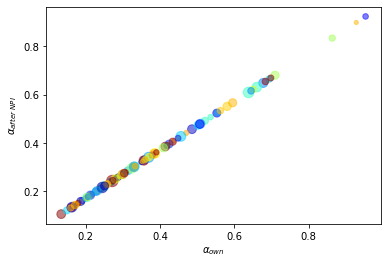

In [16]:
def money_distributor(alpha_change):
    alpha_afterNPI3=alpha_predicted-alpha_change
    money=g_inv(alpha_afterNPI3)-g_inv(alpha_predicted)
    return abs(1000000-np.sum(money))

alpha_change=fmin(money_distributor, .01, disp=False)

alpha_afterNPI3=alpha_predicted-alpha_change
scatter_plot(alpha_afterNPI3)
np.sum(g_inv(alpha_afterNPI3)-g_inv(alpha_predicted))

The uniform change in alphas due to this policy results in a linear scatter plot. 

ii.

In [17]:
total_recovered_difference(alpha_afterNPI3)

62745.25241920729

### Policy #4

i.

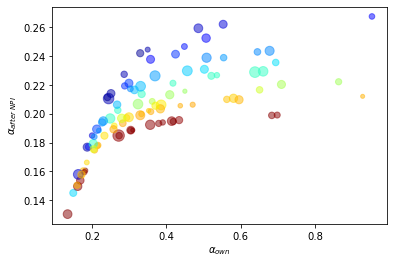

In [18]:
pmfs_beighted=[]
for i in range(100):
    pmfs_beighted.append(np.sum(Svc_0_PMF[i]*beta_old)/16)
pmfs_beighted=np.array([pmfs_beighted])[0]

percents=pmfs_beighted/np.sum(pmfs_beighted)

budgets4=percents*1000000
alpha_afterNPI4=g(g_inv(alpha_predicted)+budgets4)

scatter_plot(alpha_afterNPI4)

This graph is a rainbow. We chose the policy of spending the budget proportional to each node’s average beta value weighted by the susceptible population size in comorbidity and vulnerability compartments. The rainbow is the direct result of the colors of the scatterplot depending on social vulnerability. There appears to be a logarithmic relationship between the $\alpha_{own}$ and alpha_afterNPI values. The changes in alpha varied based off of compartment. For example, the compartment colored red had the biggest changes in alpha than any other compartment, this means that these nodes had the highest social vulnerabilties and received the biggest budgets. 

ii.

In [19]:
total_recovered_difference(alpha_afterNPI4)

312729.8382122284

989953.979711598

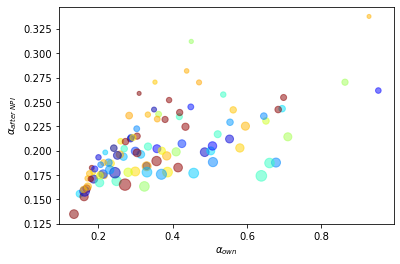

In [20]:
##EXTRA
## We attempted to find the set of alphas_afterNPI that returned the smallest total recovered population
## It did return the lowest total of all our policies, however we were having trouble setting an initial guess
## and eventually settled on using the alphas computed in policy 2 as a base
## Computing time also was an issue so we set a cap on the fmin iterations. Given more iterations, 
## it probably could have found the most optimal solution

def total_recovered(alpha_afterNPI):
    if abs(np.sum(g_inv(alpha_afterNPI)-g_inv(alpha_predicted)))<=1000000:
        S_after = np.zeros((nb_nodes, 4, 4, len(t)))
        I_after = np.zeros((nb_nodes, 4, len(t)))
        R_after = np.zeros((nb_nodes, len(t)))
        L_after = np.zeros((nb_nodes, len(t)))

        for i in range(100):  
            initial_conditions = np.concatenate(
                (S[i,:,:,29].flatten(), I[i,:,29], [R[i,29]]))

            soln = solve_ivp(
                SIR, (t[29], t[199]), initial_conditions, args=(N[i], alpha_afterNPI[i]*beta_old, gamma), t_eval=t[30:200])

            S_after[i, :, :, 30:200] = soln.y[:16].reshape(4, 4, -1)
            I_after[i, :, 30:200] = soln.y[16:20]
            R_after[i, 30:200] = soln.y[20]
            L_after[i, 30:200] = Lc@soln.y[16:20]

        recovered = abs(np.sum(R_after[:,-1]))
        return recovered
    else:
        return np.sum(R[:,-1])

best_alphas=fmin(total_recovered,alpha_afterNPI2,disp=False,maxiter=1000)
scatter_plot(best_alphas)
np.sum(g_inv(best_alphas)-g_inv(alpha_predicted))

In [21]:
total_recovered_difference(best_alphas)

343179.26686759543

## (c)

Our metric to measure similarity between nodes is the $\alpha_{own}$ values. These values are based off of the SIRL model, so they take into account each node's individual infection rates and viral loads. For this reason, nodes with similar alphas indicate that the nodes have similar disease progression, regardless of population size, as shown in the first figure below. Nodes with similar alphas should have similar changes in alpha after NPI by being given similar budgets. This is shown in the second figure below. 

Text(0.5, 1.0, 'Figure 1')

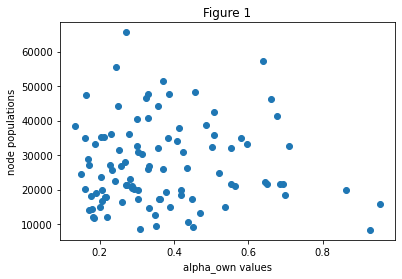

In [22]:
plt.scatter(alpha_predicted,N)
plt.xlabel('alpha_own values')
plt.ylabel('node populations')
plt.title('Figure 1')

Text(0.5, 1.0, 'Figure 2')

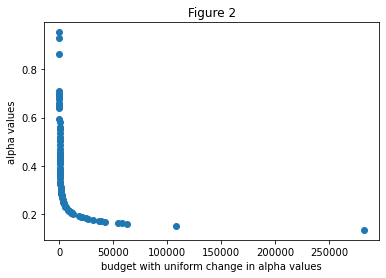

In [23]:
plt.scatter((g_inv(alpha_afterNPI3)-g_inv(alpha_predicted)),alpha_predicted)
plt.ylabel('alpha values')
plt.xlabel('budget with uniform change in alpha values')
plt.title('Figure 2')

We used policy 3 from part b as an example because the uniform change in alpha allowed for a good way to portray the budget allocation. 

In [24]:
import pandas as pd
budget = g_inv(alpha_afterNPI3)
df = pd.DataFrame(budget, alpha_predicted)
df= df.reset_index()
df.columns = ['alpha_predicted','budget']
df.sort_values(by = 'alpha_predicted')

,alpha_predicted,budget
14,0.134373,367841.440779
50,0.149597,158803.185524
96,0.159967,100077.278171
69,0.161588,93705.144177
70,0.163062,88386.180769
...,...,...
82,0.698358,409.201185
3,0.709753,384.955455
39,0.863574,147.743684
97,0.928223,81.156421


This dataframe shows that for alphas greater than around 0.3 the budgets are more similar. However, for alphas less than 0.3, as alpha steadily decreases, the budget gap between similar alphas exponentially increases. Our metric is still supported in that closer alphas will still have closer budgets. 

### Policy 1

It is unfair in that this distribution of funds doesn't take into account the different $\alpha_{own}$ or infected/susceptible population sizes of each node. Giving all the nodes the same money is good in that nodes with similar alphas will have similar changes in their alpha and be affected similarly. However,  this also means that nodes with much different alpha values are being treated similarly even though their disease conditions vary. 

Text(0, 0.5, 'Budget')

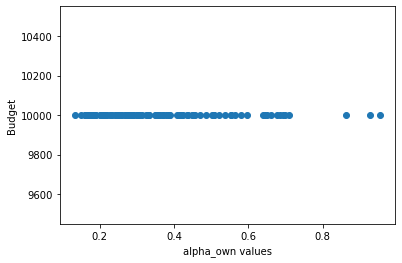

In [25]:
plt.scatter(alpha_predicted,np.array([10000 for i in range(100)]))
plt.xlabel('alpha_own values')
plt.ylabel('Budget')

Nodes with higher alphas should theoretically receive more of the budget because their recovery rate isn't as good. This is just theoretical however, because it doesn't take into account population, density, or social vulnerability of each node. 

### Policy 2

In general, bigger populations have higher infection rates because it is easier to spread. For this reason, distributing money based on population is a somewhat good tactic. This does not necessarily follow the metric of nodes with similar $\alpha_{own}$ values having a similar budget or change in alpha values because these will both depend on population for this policy. For this reason this policy is not fair. Covid rates also greatly depend on density of populations, so this policy will not always follow the similar alpha criteria. 

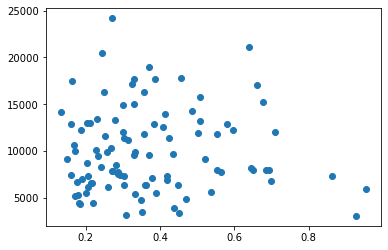

In [26]:
plt.scatter(alpha_predicted,z)

As we can see, nodes with similar alphas did not receive similar budgets, going against our similarity metric.

### Policy 3

This policy is unfair because it completely disregards the alpha similarity metric by prioritizing the same change in alpha regardless of initial alpha value. This policy shows that our alpha similarity metric is effective, because giving all alphas the same change ends up wasting money. Looking at the graph of budget vs alpha values below, we can see that alpha values decrease exponentially as budget increases. This means that for alpha values that are initially low, we are wasting more money trying to change them in order to follow the uniform change in alpha values policy. For this reason, this policy had the smallest effect on decreasing recovered populations. 

Text(0, 0.5, 'alpha')

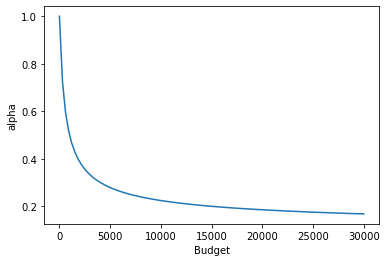

In [27]:
x = np.linspace(0.001,30000,100)
plt.plot(x,g(x))
plt.xlabel('Budget')
plt.ylabel('alpha')

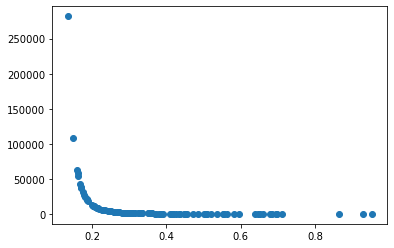

In [28]:
plt.scatter(alpha_predicted,g_inv(alpha_afterNPI3)-g_inv(alpha_predicted))

As we can see, a single bezos node at about 0.1 hoarded almost a third of the million dollars. 

### Policy 4

The SIRL model is affected by the SV/comorbidity compartments. This means that the $\alpha_{own}$ values are somewhat being taken into account when we consider these compartments for budget allocation. However, our graph in policy 4 shows that similar alpha values did not end up receiving similar budgets. This shows that this policy isn't fair. This may seem contradictory because the compartments should affect similar alphas the same way considering they are calculated from the SIRL model, but our alphas aren't necessarily directly related to the compartments.  

Text(0, 0.5, 'budgets')

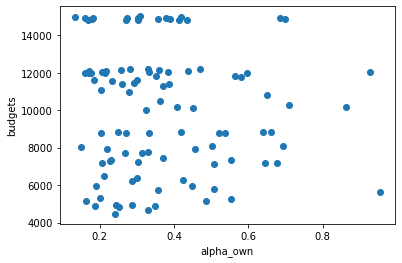

In [29]:
plt.scatter(alpha_predicted,budgets4)
plt.xlabel('alpha_own')
plt.ylabel('budgets')